In [211]:
!pip install micromlgen


In [326]:
import pandas as pd
import numpy as np
from sktime.classification.kernel_based import RocketClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


def load_motion_data(file_path, timepoints, label):
    """ Load motion data from a file and assign a class label. """
    df = pd.read_csv(file_path, sep=r'\s+', header=None)
    df.columns = ["accX", "accY", "accZ", "gyrX", "gyrY", "gyrZ"]

    n_timepoints = timepoints
    n_features = 6  # (accX, accY, accZ, gyrX, gyrY, gyrZ)
    n_instances = len(df) // n_timepoints  # Calculate number of full sequences

    df = df.iloc[: n_instances * n_timepoints]  # Ensure only full sequences are used

    X_3d = df.values.reshape(n_instances, n_timepoints, n_features)
    X_3d = np.transpose(X_3d, (0, 2, 1))  # Convert to (n_instances, n_features, n_timepoints)

    y_labels = np.full(n_instances, label)  # Assign the given class label
    return X_3d, y_labels



In [213]:

# Load both datasets with assigned labels
X_circles, y_circles = load_motion_data("circles6.txt", 100, label=0)  # Class 0
X_side, y_side = load_motion_data("side6.txt", 100, label=1)  # Class 1
X_updown, y_updown = load_motion_data("up_down6.txt", 100, label=2)  # Class 2
X_diagonal, y_diagonal = load_motion_data("diagonal1.txt", 100, label=3)  # Class 3
X_still, y_still = load_motion_data("still.txt", 100, label=4)  # Class 4

# Combine the two datasets
X = np.concatenate((X_circles, X_side, X_updown, X_diagonal, X_still), axis=0)
y = np.concatenate((y_circles, y_side, y_updown, y_diagonal, y_still), axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)



In [214]:
for i in range(25):
    print(y[i])

0
2
1
2
3
2
4
0
2
4
3
4
4
1
2
3
4
2
1
1
4
4
0
0
3


In [215]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train RocketClassifier
model1 = RocketClassifier(num_kernels=100)
model1.fit(X_train, y_train)



RocketClassifier(num_kernels=100)

In [216]:
# Flatten X_train and X_test for RandomForest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train RandomForest on flattened data
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier()
model2.fit(X_train_flat, y_train)




RandomForestClassifier()

In [217]:
y_pred = model2.predict(X_test_flat)
accuracy_forest = accuracy_score(y_test, y_pred)
print("Random forest accuracy: ", accuracy_forest)

Random forest accuracy:  0.9629629629629629


In [218]:
X_train_flat.shape, X_train.shape

((216, 600), (216, 6, 100))

In [219]:
from sklearn import tree

model3 = tree.DecisionTreeClassifier()
model3.fit(X_train_flat, y_train)

DecisionTreeClassifier()

In [220]:
y_pred_tree = model3.predict(X_test_flat)
accuracy_tree = accuracy_score(y_test, y_pred_tree) 
print("Decision tree accuracy: ", accuracy_tree)

Decision tree accuracy:  0.7962962962962963


In [221]:
X_test_flat.shape, y_pred_tree.shape

((54, 600), (54,))

In [222]:
single_sample = X_test_flat[3].reshape(1, -1)  # Reshape to (1, 600)
y_pred_single = model3.predict(single_sample)
print("Predicted class for single sample:", y_pred_single[0])

Predicted class for single sample: 4


In [223]:
X_test_flat[3].reshape(1, -1)

array([[-0.003, -0.002, -0.003, -0.003, -0.002, -0.001, -0.003, -0.003,
        -0.003, -0.003, -0.003, -0.003, -0.003, -0.003, -0.002, -0.002,
        -0.002, -0.001, -0.002, -0.002, -0.003, -0.004, -0.003, -0.004,
        -0.002, -0.002, -0.003, -0.002, -0.002, -0.004, -0.003, -0.002,
        -0.003, -0.003, -0.003, -0.002, -0.002, -0.003, -0.002, -0.003,
        -0.003, -0.001, -0.003, -0.003, -0.002, -0.002, -0.003, -0.003,
        -0.003, -0.003, -0.004, -0.004, -0.005, -0.003, -0.002, -0.004,
        -0.002, -0.002, -0.002, -0.002, -0.002, -0.001, -0.002, -0.003,
        -0.003, -0.002, -0.004, -0.003, -0.002, -0.002, -0.002, -0.002,
        -0.003, -0.004, -0.003, -0.003, -0.003, -0.004, -0.003, -0.004,
        -0.003, -0.003, -0.004, -0.003, -0.002, -0.003, -0.003, -0.003,
        -0.004, -0.002, -0.004, -0.002, -0.002, -0.001, -0.004, -0.003,
        -0.002, -0.003, -0.002, -0.002,  0.001,  0.   ,  0.   ,  0.   ,
        -0.   , -0.001,  0.001,  0.001, -0.001,  0.   ,  0.   , 

In [224]:
# Predict and evaluate
y_pred_rf = model2.predict(X_test_flat)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("RandomForest Test Accuracy:", accuracy_rf)

RandomForest Test Accuracy: 0.9629629629629629


In [225]:
def try_unseen(filename, model):
    """Loads unseen motion data, reformats it if needed, and runs prediction."""
    import pandas as pd
    import numpy as np
    
    # Load the new unseen data
    df = pd.read_csv(filename, sep=r'\s+', header=None)
    df.columns = ["accX", "accY", "accZ", "gyrX", "gyrY", "gyrZ"]

    n_timepoints = 100  # Each instance contains 100 samples
    n_features = 6  # (accX, accY, accZ, gyrX, gyrY, gyrZ)
    n_instances = len(df) // n_timepoints  # Calculate number of instances

    df = df.iloc[: n_instances * n_timepoints]  # Ensure only full sequences are used

    # Reshape data into (n_instances, n_timepoints, n_features)
    X_new = df.values.reshape(n_instances, n_timepoints, n_features)
    X_new = np.transpose(X_new, (0, 2, 1))  # Convert to (n_instances, n_features, n_timepoints)

    # Check if the model is RandomForest (which needs 2D input)
    if isinstance(model, RandomForestClassifier):
        X_new = X_new.reshape(X_new.shape[0], -1)  # Flatten to (n_instances, n_features * n_timepoints)

    # Predict the motion class
    y_new_pred = model.predict(X_new)

    # Map numerical predictions to class names
    class_labels = {
        0: "Circles",
        1: "Side",
        2: "Up-Down",
        3: "Diagonal"
    }
    
    # Convert predictions to readable labels
    y_new_pred_labels = [class_labels.get(pred, "Unknown") for pred in y_new_pred]

    # Print the predictions with class names
    print(f"Predicted Classes for {filename}:", y_new_pred_labels)


In [226]:
try_unseen("updown_test1.txt", model2)

Predicted Classes for updown_test1.txt: ['Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Circles', 'Circles', 'Circles']


In [227]:
def load_unseen_data(file_path):
    """Load new motion data (unlabeled) for prediction."""
    df = pd.read_csv(file_path, sep=r'\s+', header=None)
    df.columns = ["accX", "accY", "accZ", "gyrX", "gyrY", "gyrZ"]

    n_timepoints = 100  # Each instance contains 100 samples
    n_features = 6  # (accX, accY, accZ, gyrX, gyrY, gyrZ)
    n_instances = len(df) // n_timepoints  # Number of sequences

    df = df.iloc[: n_instances * n_timepoints]  # Keep only full sequences

    X_new = df.values.reshape(n_instances, n_timepoints, n_features)
    X_new = np.transpose(X_new, (0, 2, 1))  # Convert to (n_instances, n_features, n_timepoints)

    return X_new



In [228]:
# Load new unseen motion data
X_new = load_unseen_data("circles6_test1.txt")

# Predict the motion class
y_new_pred = model1.predict(X_new)

# Print the predicted class labels
print("Predicted Classes for New Data:", y_new_pred)


Predicted Classes for New Data: [0 0 0 0]


In [229]:
# Load new unseen motion data
X_new = load_unseen_data("side6_test1.txt")

# Predict the motion class
y_new_pred = model1.predict(X_new)

# Print the predicted class labels
print("Predicted Classes for New Data:", y_new_pred)


Predicted Classes for New Data: [1 1 1 1 1 1 1 1 1 1]


In [230]:
# Load new unseen motion data
X_new = load_unseen_data("mixed1.txt")

# Predict the motion class
y_new_pred = model1.predict(X_new)

# Print the predicted class labels
print("Predicted Classes for New Data:", y_new_pred)


Predicted Classes for New Data: [4 1 0 1 1 0 0 1 1 1 0 3 0 1 1 1 1 1 1 1 1]


In [231]:
# Load new unseen motion data
X_new = load_unseen_data("updown_test1.txt")

# Predict the motion class
y_new_pred = model1.predict(X_new)

# Print the predicted class labels
print("Predicted Classes for New Data:", y_new_pred)


Predicted Classes for New Data: [2 2 2 2 2 2 2 0 0 0]


In [232]:
# Define class names
class_labels = {
    0: "Circles",
    1: "Side",
    2: "Up-Down",
    3: "Diagonal"
}

# Predict the motion class
y_new_pred = model1.predict(X_new)

# Convert numeric predictions to class names
y_new_pred_labels = [class_labels[pred] for pred in y_new_pred]

# Print the predictions with class names
print("Predicted Classes for New Data:", y_new_pred_labels)


Predicted Classes for New Data: ['Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Up-Down', 'Circles', 'Circles', 'Circles']


In [233]:
from micromlgen import port

# Export the model to plain C++
c_code = port(model2)

# Save the model to a .h file
with open("model_randomForestClassifier.h", "w") as f:
    f.write(c_code)

print("Model exported to model_randomForestClassifier.h")


Model exported to model_randomForestClassifier.h


In [234]:
# ------------- #
# Now lets try building a model for skiing
# ------------- #

In [235]:
# Load both datasets with assigned labels
X_saxning, y_saxning = load_motion_data("saxning.txt", 100, label=0)  # Class 0
X_skate, y_skate = load_motion_data("skate.txt", 100, label=1)  # Class 1
X_stakning, y_stakning = load_motion_data("stakning.txt", 100, label=2)  # Class 2
X_stakningFrnskjut, y_stakningFrnskjut = load_motion_data("stakning_frnskjut.txt", 100, label=3)  # Class 3

# Combine the two datasets
X_ski = np.concatenate((X_saxning, X_skate, X_stakning, X_stakningFrnskjut), axis=0)
y_ski = np.concatenate((y_saxning, y_skate, y_stakning, y_stakningFrnskjut), axis=0)

# Shuffle the dataset
X_ski, y_ski = shuffle(X_ski, y_ski, random_state=42)


In [236]:
# Split into training and test sets
X_ski_train, X_ski_test, y_ski_train, y_ski_test = train_test_split(X_ski, y_ski, test_size=0.2, random_state=42, stratify=y_ski)

# Flatten X_train and X_test for RandomForest
X_ski_train_flat = X_ski_train.reshape(X_ski_train.shape[0], -1)
X_ski_test_flat = X_ski_test.reshape(X_ski_test.shape[0], -1)

# Train RandomForest on flattened data
from sklearn.ensemble import RandomForestClassifier

modelRandomForest_ski = RandomForestClassifier()
modelRandomForest_ski.fit(X_ski_train_flat, y_ski_train)


RandomForestClassifier()

In [237]:
y_ski_pred = modelRandomForest_ski.predict(X_ski_test_flat)
accuracy_forest = accuracy_score(y_ski_test, y_ski_pred)
print("Random forest accuracy for cross country skiing: ", accuracy_forest)

Random forest accuracy for cross country skiing:  0.8666666666666667


In [238]:
# Resultatet på 88% beror förmodligen på att saxning hade mest data. Ska göra samma sak men 
# nu ska de alla stilarna ha lika mycket.

In [298]:
# Load both datasets with assigned labels
X_saxningEqual, y_saxningEqual = load_motion_data("saxningEqual.txt", 100, label=0)  # Class 0
X_skateEqual, y_skateEqual = load_motion_data("skateEqual.txt", 100, label=1)  # Class 1
X_stakningEqual, y_stakningEqual = load_motion_data("stakningEqual.txt", 100, label=2)  # Class 2
X_stakningFrnskjutEqual, y_stakningFrnskjutEqual = load_motion_data("stakning_frnskjutEqual.txt", 100, label=3)  # Class 3

print(len(y_saxningEqual))
print(len(y_skateEqual))
print(len(y_stakningEqual))
print(len(y_stakningFrnskjutEqual))


27
27
27
27


In [300]:
def prepare_data(datasets, labels, test_size=0.2, random_state=42):
    """
    Combines multiple datasets, shuffles, splits into train-test, and flattens for RandomForest.
    
    Parameters:
        datasets (list of np.array): List of feature arrays.
        labels (list of np.array): List of label arrays.
        test_size (float): Proportion of dataset to allocate for testing.
        random_state (int): Seed for reproducibility.
    
    Returns:
        X_train_flat, X_test_flat, y_train, y_test
    """
    # Combine the datasets
    X_combined = np.concatenate(datasets, axis=0)
    y_combined = np.concatenate(labels, axis=0)

    # Shuffle the dataset
    X_combined, y_combined = shuffle(X_combined, y_combined, random_state=random_state)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_combined, y_combined, test_size=test_size, random_state=random_state, stratify=y_combined
    )

    # Flatten for RandomForest
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    return X_train_flat, X_test_flat, y_train, y_test

In [302]:
X_skiEqual_train_flat, X_skiEqual_test_flat, y_skiEqual_train, y_skiEqual_test = prepare_data(
    [X_saxningEqual, X_skateEqual, X_stakningEqual, X_stakningFrnskjutEqual], 
    [y_saxningEqual, y_skateEqual, y_stakningEqual, y_stakningFrnskjutEqual]
)

In [304]:

# Train RandomForest on flattened data
from sklearn.ensemble import RandomForestClassifier

modelRandomForest_skiEqual = RandomForestClassifier()
modelRandomForest_skiEqual.fit(X_skiEqual_train_flat, y_skiEqual_train)


RandomForestClassifier()

In [322]:
def evaluate_model(model, X_test, y_test, class_labels):
    """
    Evaluates a trained model by computing accuracy and displaying a confusion matrix.

    Parameters:
        model (RandomForestClassifier): Trained RandomForest model.
        X_test (np.array): Flattened test set features.
        y_test (np.array): Test set labels.
        class_labels (list of str): List of class names for confusion matrix labels.

    Returns:
        accuracy (float): The accuracy score of the model.
    """
    # Predict on test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Random forest accuracy for cross country skiing: {accuracy:.4f}")

    # Create and display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues")
    plt.show()

    return accuracy

Random forest accuracy for cross country skiing: 0.8636


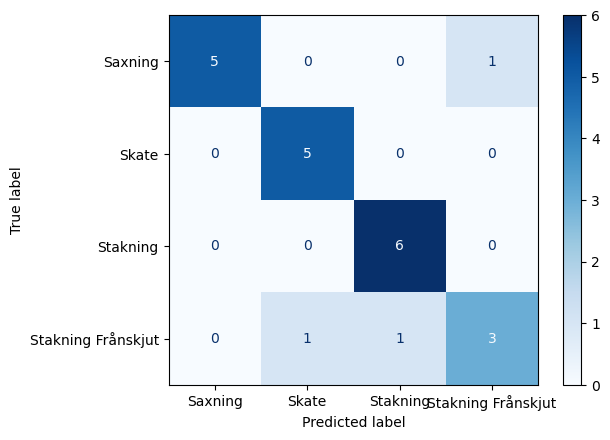

0.8636363636363636

In [328]:
# Call the function with your trained model and test data
class_labels = ["Saxning", "Skate", "Stakning", "Stakning Frånskjut"]
evaluate_model(modelRandomForest_skiEqual, X_skiEqual_test_flat, y_skiEqual_test, class_labels)

In [334]:
# 86% accuracy är mycket bättre än vad jag trodde att det skulle vara.


In [332]:
# Jag misstänker att den har stora problem med stakning frånskjut just för att jag har 
# sensorn på ena benet och frånskjutet sker på vartannat ben. Och eftersom en batch bara är 50Hz i 100 samples
# (alltså 2 sekunder) så tror jag att frånskjutet på sensorbenet i vissa batcher inte hinner komma. Vilket gör att den
# då kommer att likna stakning mer. 
# Därför tror jag att det kan vara en bra idé att jag drar ut och skidar igen men denna gång kör 150 samples, alltså 3 sekunder.
# Då borde frånskjutet alltid komma med. 

In [314]:
# Load both datasets with assigned labels
X_saxning2, y_saxning2 = load_motion_data("saxning_ski2.txt", 100, label=0)  # Class 0
X_skate2, y_skate2 = load_motion_data("skate_ski2.txt", 100, label=1)  # Class 1
X_diagonal2, y_diagonal2 = load_motion_data("diagonalande_ski2.txt", 100, label=2)  # Class 2
X_stakning2, y_stakning2 = load_motion_data("stakning_ski2.txt", 100, label=3)  # Class 3
X_stilla2, y_stilla2 = load_motion_data("stilla_ski2.txt", 100, label=4)  # Class 4
X_backe_ner2, y_backe_ner2 = load_motion_data("backe_ner_ski2.txt", 100, label=5)  # Class 5

print(len(y_saxning2))
print(len(y_skate2))
print(len(y_diagonal2))
print(len(y_stakning2))
print(len(y_stilla2))
print(len(y_backe_ner2))



63
69
82
80
40
45


In [318]:
X_ski2_train_flat, X_ski2_test_flat, y_ski2_train, y_ski2_test = prepare_data(
    [X_saxning2, X_skate2, X_diagonal2, X_stakning2, X_stilla2, X_backe_ner2], 
    [y_saxning2, y_skate2, y_diagonal2, y_stakning2, y_stilla2, y_backe_ner2]
)

In [320]:
from sklearn.ensemble import RandomForestClassifier

modelRandomForest_ski2 = RandomForestClassifier()
modelRandomForest_ski2.fit(X_ski2_train_flat, y_ski2_train)

RandomForestClassifier()

Random forest accuracy for cross country skiing: 0.8947


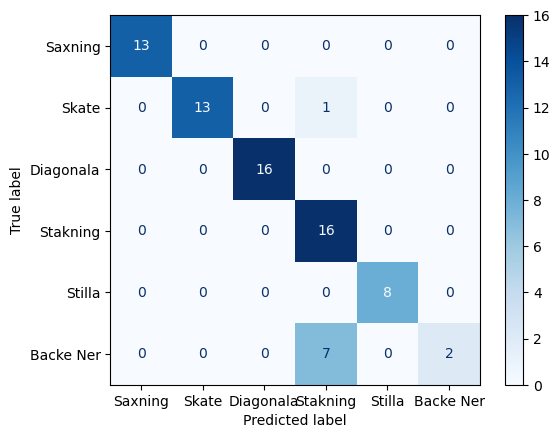

0.8947368421052632

In [337]:
# Define class labels for the evaluation
class_labels_ski2 = ["Saxning", "Skate", "Diagonala", "Stakning", "Stilla", "Backe Ner"]

# Evaluate the trained RandomForest model
evaluate_model(modelRandomForest_ski2, X_ski2_test_flat, y_ski2_test, class_labels_ski2)


In [339]:
# Tycker att resultatet ser mycket bra ut. Men det är väldigt uppenbart att Backe ner har problem. 
# Så kommer att ta bort nerförsbackar då de är alldeles för lika stakning i rörelsemönstret.
# För att kunna få in bra klassificering av nerförsbackar så hade jag behövt en accelerometer på armen 
# och inte bara benet.

In [369]:
# Load both datasets with assigned labels
X_saxning3, y_saxning3 = load_motion_data("saxning_ski2.txt", 100, label=0)  # Class 0
X_skate3, y_skate3 = load_motion_data("skate_ski2.txt", 100, label=1)  # Class 1
X_diagonal3, y_diagonal3 = load_motion_data("diagonalande_ski2.txt", 100, label=2)  # Class 2
X_stakning3, y_stakning3 = load_motion_data("stakning_ski2.txt", 100, label=3)  # Class 3
X_stilla3, y_stilla3 = load_motion_data("stilla_ski2.txt", 100, label=4)  # Class 4

print(len(y_saxning3))
print(len(y_skate3))
print(len(y_diagonal3))
print(len(y_stakning3))



63
69
82
80


In [371]:
X_ski3_train_flat, X_ski3_test_flat, y_ski3_train, y_ski3_test = prepare_data(
    [X_saxning3, X_skate3, X_diagonal3, X_stakning3, X_stilla3], 
    [y_saxning3, y_skate3, y_diagonal3, y_stakning3, y_stilla3]
)

In [373]:
from sklearn.ensemble import RandomForestClassifier

modelRandomForest_ski3 = RandomForestClassifier()
modelRandomForest_ski3.fit(X_ski2_train_flat, y_ski2_train)

RandomForestClassifier()

Random forest accuracy for cross country skiing: 0.9851


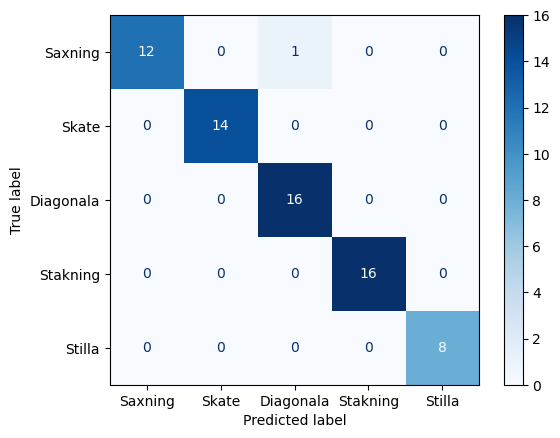

0.9850746268656716

In [374]:
# Define class labels for the evaluation
class_labels_ski3 = ["Saxning", "Skate", "Diagonala", "Stakning", "Stilla"]

# Evaluate the trained RandomForest model
evaluate_model(modelRandomForest_ski3, X_ski3_test_flat, y_ski3_test, class_labels_ski3)


In [351]:
# Vilken succee! Har nu ökat samplingstiden till 3 sekunder (50 Hz). 
# Och har ersatt tekniken stakning med frånskjut till diagonalande eftersom stakning med frånskjut
# kommer se ut som stakning om man gör det för långsamt.